## Siamese network 
Steps:
1. load word embeding and document embedding
2. create pytorch dataset and dataloader
3. Try Contrastive loss and triplet loss
4. further improve negative sampling (e.g. hard negative or word2vec negative sampling)

### raw data
* word embedding: glove
* doc text: ./data/IMDB.txt

### preprocess
1. filter too frequent and less frequent words
2. stemming

### model
1. Siamese
2. TopK
3. DNN
4. Lasso
5. LassoGAN

### evaluation
1. F1
2. NDCG
    1. MAP
    2. MRR
    3. ERR

In [23]:
from collections import defaultdict
import math
import numpy as np 
import re
import torch
import torch.nn as nn
from itertools import cycle
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm.auto import tqdm

from sklearn.metrics import ndcg_score
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt 
import pandas as pd

## Preprocess config

In [24]:
config = {}

config["n_document"] = 10000
config["min_word_freq_threshold"] = 20
config["topk_word_freq_threshold"] = 100
config["document_vector_agg"] = 'TF-IDF'
config["select_topk_TFIDF"] = None


In [25]:
# load word embedding
embedding_file = "../data/glove.6B.100d.txt"

word2embedding = dict()
word_dim = int(re.findall(r".(\d+)d",embedding_file)[0])

with open(embedding_file,"r") as f:
    for line in tqdm(f):
        line = line.strip().split()
        word = line[0]
        embedding = list(map(float,line[1:]))
        word2embedding[word] = embedding

print("Number of words:%d" % len(word2embedding))

0it [00:00, ?it/s]

Number of words:400000


In [26]:
class Vocabulary:
    def __init__(self, word2embedding, min_word_freq_threshold=0, topk_word_freq_threshold=0):
        # The low frequency words will be assigned as <UNK> token
        self.itos = {0: "<UNK>"}
        self.stoi = {"<UNK>": 0}
        
        self.word2embedding = word2embedding
        self.min_word_freq_threshold = min_word_freq_threshold
        self.topk_word_freq_threshold = topk_word_freq_threshold
        
        self.word_freq_in_corpus = defaultdict(int)
        self.IDF = {}
        self.ps = PorterStemmer()
        
    def __len__(self):
        return len(self.itos)

#     @staticmethod
    def tokenizer_eng(self, text):
        text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
        text = text.strip().split()
        
        return [self.ps.stem(w) for w in text]

    def build_vocabulary(self, sentence_list):
        
        self.doc_freq = defaultdict(int) # # of document a word appear
        self.document_num = len(sentence_list)
        self.word_vectors = [[0]*word_dim] # unknown word emb
        
        for sentence in tqdm(sentence_list, desc="Preprocessing documents"):
            # for doc_freq
            document_words = set()
            
            for word in self.tokenizer_eng(sentence):
                # pass unknown word
                if word not in self.word2embedding:
                    continue
                    
                # calculate word freq
                self.word_freq_in_corpus[word] += 1
                document_words.add(word)
                
            for word in document_words:
                self.doc_freq[word] += 1
        
        # calculate IDF
        print('doc num', self.document_num)
        for word, freq in self.doc_freq.items():
            self.IDF[word] = math.log(self.document_num / (freq+1))
        
        # delete less freq words:
        delete_words = []
        for word, v in self.word_freq_in_corpus.items():
            if v < self.min_word_freq_threshold:
                delete_words.append(word)     
        for word in delete_words:
            del self.IDF[word]    
            del self.word_freq_in_corpus[word]    
        
        # delete too freq words
        print('eliminate freq words')
        IDF = [(word, freq) for word, freq in self.IDF.items()]
        IDF.sort(key=lambda x: x[1])

        for i in range(self.topk_word_freq_threshold):
            print(word)
            word = IDF[i][0]
            del self.IDF[word]
            del self.word_freq_in_corpus[word]
        
        # construct word_vectors
        idx = 1
        for word in self.word_freq_in_corpus:
            self.word_vectors.append(self.word2embedding[word])
            self.stoi[word] = idx
            self.itos[idx] = word
            idx += 1
            
    def calculate_document_vector(self, sentence_list, agg, select_topk_TFIDF=None):
        document_vectors = []
        document_answers = []
        document_answers_w = []
        
        for sentence in tqdm(sentence_list, desc="calculate document vectors"):
            document_vector = np.zeros(len(self.word_vectors[0]))
            select_words = []
            for word in self.tokenizer_eng(sentence):
                # pass unknown word
                if word not in self.stoi:
                    continue
                else:
                    select_words.append(word)

            # select topk TDIDF
            if select_topk_TFIDF is not None:
                doc_TFIDF = defaultdict(float)
                for word in select_words:    
                    doc_TFIDF[word] += self.IDF[word]

                doc_TFIDF_l = [(word, TFIDF) for word, TFIDF in doc_TFIDF.items()]
                doc_TFIDF_l.sort(key=lambda x:x[1], reverse=True)
                
                select_topk_words = set(list(map(lambda x:x[0], doc_TFIDF_l[:select_topk_TFIDF])))
                select_words = [word for word in select_words if word in select_topk_words]
            else:
                pass
            
            total_weight = 0
            # aggregate to doc vectors
            for word in select_words:
                if agg == 'mean':
                    document_vector += self.word2embedding[word]
                    total_weight += 1
                elif agg == 'TF-IDF':
                    document_vector += np.array(self.word2embedding[word]) * self.IDF[word]
                    total_weight += self.IDF[word]

            if len(select_words) == 0:
                print('error', sentence)
                continue
            else:
                document_vector /= len(select_words)
                total_weight /= len(select_words)
            
            document_vectors.append(document_vector)
            document_answers.append(select_words)
            document_answers_w.append(total_weight)
        
        # get answers
        document_answers_idx = []    
        for ans in document_answers:
            ans_idx = []
            for token in ans:
                if token in self.stoi:
                    ans_idx.append(self.stoi[token])                    
            document_answers_idx.append(ans_idx)
            
        return document_vectors, document_answers_idx, document_answers_w
        
    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [27]:
class CBowDataset(Dataset):
    def __init__(self, 
                 raw_data_file_path,
                 word2embedding,
                 skip_header = False,
                 n_document = None, # read first n document
                 min_word_freq_threshold = 20, # eliminate less freq words
                 topk_word_freq_threshold = 5, # eliminate smallest k IDF words
                 select_topk_TFIDF = None, # select topk tf-idf as ground-truth
                 document_vector_agg = 'mean',
                 ):

        assert document_vector_agg in ['mean', 'TF-IDF']
        
        # raw documents
        self.documents = []
        
        with open(raw_data_file_path,'r',encoding='utf-8') as f:
            if skip_header:
                f.readline()
            for line in tqdm(f, desc="Loading documents"):
                # read firt n document
                if n_document is not None and len(self.documents) >= n_document:
                    break    
                self.documents.append(line.strip("\n"))

        # build vocabulary
        self.vocab = Vocabulary(word2embedding, min_word_freq_threshold, topk_word_freq_threshold)
        self.vocab.build_vocabulary(self.documents)
        self.vocab_size = len(self.vocab)

        # calculate document vectors
        self.document_vectors, self.document_answers, self.document_answers_w = self.vocab.calculate_document_vector(self.documents, \
                                                                                           document_vector_agg, select_topk_TFIDF)
        # train-test split
        # training
        self.train_split_ratio = 0.8
        self.train_length = int(len(self.document_answers) * self.train_split_ratio)
        self.train_vectors = self.document_vectors[:self.train_length]
        self.train_words = self.document_answers[:self.train_length]
        self.document_ids = list(range(self.train_length))
        self.generator = cycle(self.context_target_generator())
        self.dataset_size = sum([len(s) for s in self.train_words])
        
        # testing
        self.test_vectors = self.document_vectors[self.train_length:]
        self.test_words = self.document_answers[self.train_length:]

    def context_target_generator(self):
        np.random.shuffle(self.document_ids) # inplace shuffle

        # randomly select a document and create its training example
        for document_id in self.document_ids: 
            word_list = set(self.train_words[document_id])
            negative_sample_space = list(set(range(self.vocab_size)) - word_list)
            negative_samples = np.random.choice(negative_sample_space,size=len(word_list),replace = False)
            for word_id, negative_wordID in zip(word_list, negative_samples):
                yield [document_id, word_id, negative_wordID]
                
    def __getitem__(self, idx):
        doc_id, word_id, negative_wordID = next(self.generator)
        doc_id = torch.FloatTensor(self.document_vectors[doc_id])
        word_id = torch.FloatTensor(self.vocab.word_vectors[word_id])
        negative_word = torch.FloatTensor(self.vocab.word_vectors[negative_wordID])

        return doc_id, word_id, negative_word

    def __len__(self):
        return self.dataset_size 


In [28]:
# load and build torch dataset
data_file_path = '../data/IMDB.txt'

print("Building dataset....")
dataset = CBowDataset(
                    raw_data_file_path=data_file_path,
                    word2embedding=word2embedding,
                    skip_header=False,
                    n_document = config["n_document"],
                    min_word_freq_threshold = config["min_word_freq_threshold"],
                    topk_word_freq_threshold = config["topk_word_freq_threshold"],
                    document_vector_agg = config["document_vector_agg"],
                    select_topk_TFIDF = config["select_topk_TFIDF"]
                    )
print("Finish building dataset!")
print(f"Number of documents:{len(dataset.documents)}")
print(f"Number of words:{dataset.vocab_size}")

Building dataset....


Loading documents: 0it [00:00, ?it/s]

Preprocessing documents:   0%|          | 0/10000 [00:00<?, ?it/s]

doc num 10000
eliminate freq words
boel
the
and
a
of
to
is
it
thi
in
that
i
for
with
but
as
on
wa
be
film
one
not
are
have
all
an
you
at
by
from
who
like
hi
ha
so
he
time
about
out
there
if
veri
see
good
what
more
they
when
just
some
or
make
watch
great
get
well
my
other
up
can
love
also
which
would
their
will
even
most
her
me
had
much
than
first
do
way
into
play
end
were
no
best
scene
think
been
how
go
look
show
made
she
after
we
year
mani
work
know
too
seen
act


calculate document vectors:   0%|          | 0/10000 [00:00<?, ?it/s]

Finish building dataset!
Number of documents:10000
Number of words:4527


In [36]:
# check test doc vectors' correctness
word_vectors = np.array(dataset.vocab.word_vectors)
word_vectors.shape

pred = np.zeros(100)
cnt = 0
for word_idx in dataset.test_words[0]:
    pred += word_vectors[word_idx] * dataset.vocab.IDF[dataset.vocab.itos[word_idx]]
    cnt += 1
print(dataset.test_vectors[0] - pred/cnt)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [37]:
## create tfidf_ans
document_answers = dataset.document_answers

onehot_ans = np.zeros((len(document_answers), word_vectors.shape[0]))
tfidf_ans = np.zeros((len(document_answers), word_vectors.shape[0]))
print(tfidf_ans.shape)

for i in tqdm(range(len(document_answers))):
    for word_idx in document_answers[i]:
        tfidf_ans[i, word_idx] += dataset.vocab.IDF[dataset.vocab.itos[word_idx]]
        onehot_ans[i, word_idx] += 1

(10000, 4527)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [38]:
class TestDataset(Dataset):
    def __init__(self, 
                 doc_vectors,
                 ans_words,
                 ):
        self.doc_vectors = doc_vectors
        self.ans_words = ans_words
        assert len(doc_vectors) == len(ans_words)
        
    def __getitem__(self, idx):
        doc_vec = torch.FloatTensor(self.doc_vectors[idx])
        ans_w = torch.tensor(list(set(self.ans_words[idx])))
        return doc_vec, ans_w

    def collate_fn(self,batch):
        # Batch: List of tuples [(batch1), (batch2)]
        
        doc_vec = torch.cat([item[0].unsqueeze(0) for item in batch], dim=0)
        ans_w = [item[1] for item in batch]
        ans_w = pad_sequence(ans_w, batch_first=True, padding_value=-1)
        
        return doc_vec, ans_w 

    def __len__(self):
        return len(self.doc_vectors)


In [39]:
class TripletNet(nn.Module):
    def __init__(self, hdim):
        super(TripletNet, self).__init__()
        self.fc = nn.Sequential(nn.Linear(hdim, 256),
                        nn.PReLU(),
                        nn.Linear(256, 256),
                        nn.PReLU(),
                        nn.Linear(256, 2)
                        )


    def forward(self, x1, x2, x3):
        output1 = self.fc(x1)
        output2 = self.fc(x2)
        output3 = self.fc(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        return self.fc(x)

In [40]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [41]:
margin = 1.
BATCH_SIZE = 1024
EPOCH = 20

device = "cuda:0"
model = TripletNet(word_dim).to(device)
loss_fn = TripletLoss(margin).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [42]:
train_loader = DataLoader(
                        dataset, 
                        batch_size=BATCH_SIZE,
                        num_workers=4,
                        shuffle=True,
                        )

In [43]:
test_docvec = dataset.test_vectors
test_ans = dataset.test_words
test_dataset = TestDataset(test_docvec,test_ans)
test_loader = DataLoader(test_dataset,                         
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         collate_fn=test_dataset.collate_fn)
word_embedding_tensor = torch.FloatTensor(dataset.vocab.word_vectors).to(device)

In [44]:
def evaluate(test_word_emb, loader,Ks = [50,100,150,200]):
    avg_precision, avg_recall = [], []
    for batch in test_loader:
        batch = [item.to(device) for item in batch]
        emb, ans = batch
        emb = model.get_embedding(emb)
        scores = torch.cdist(emb, test_word_emb)
        ans_length = torch.sum((~ans.eq(-1)).float(), dim=-1)
        mask = ~ans.eq(-1).unsqueeze(-1)
        
        # calculate precision and recall
        tmp_pr, tmp_re = [],[]
        for K in Ks:
            top_indices = torch.argsort(scores,dim=1)[:,:K]
            hit = top_indices.unsqueeze(-2) == ans.unsqueeze(-1)
            hit = torch.sum((hit * mask).flatten(1),dim=-1)
            precision = hit / K
            recall = hit / ans_length
            tmp_pr.append(precision)
            tmp_re.append(recall)
        tmp_pr = torch.stack(tmp_pr).T.detach().cpu().numpy().tolist()
        tmp_re = torch.stack(tmp_re).T.detach().cpu().numpy().tolist()
        avg_precision.extend(tmp_pr)
        avg_recall.extend(tmp_re)
        
    avg_precision = np.mean(avg_precision,axis=0)
    avg_recall = np.mean(avg_recall, axis=0)
    for idx, kval in enumerate(Ks):
        print(f"[K={kval}] Precision:{avg_precision[idx]:.4f} Recall:{avg_recall[idx]:.4f}")
    return avg_precision, avg_recall

In [45]:
# for epoch in range(EPOCH):
#     avg_loss = []
#     model.train()
#     for batch in tqdm(train_loader):
#         batch = [item.to(device) for item in batch]
#         doc_id,pos_w,neg_w = batch
#         optimizer.zero_grad()
#         loss = loss_fn(*model(doc_id,pos_w,neg_w))
#         loss.backward()
#         optimizer.step()
#         avg_loss.append(loss.item())
#     avg_loss = np.mean(avg_loss)
#     print(f"Loss:{avg_loss:4f}")
    
#     # evaluate
#     model.eval()
#     test_word_emb = model.get_embedding(word_embedding_tensor)
#     res = evaluate(test_word_emb,test_loader)

In [46]:
from sklearn.metrics import ndcg_score

def evaluate_NDCG(test_word_emb, loader, topk=None):
    NDCGs = defaultdict(list)
    
    for batch in (test_loader):
        batch = [item.to(device) for item in batch]
        emb, ans = batch
        TFIDF_ans = np.zeros((len(ans), test_word_emb.shape[0]))
        for i in range(len(ans)):
            ans_row = ans[i]
            ans_row = ans_row[~ans_row.eq(-1)]
            ans_row = ans_row[~ans_row.eq(0)]
            for word_id in ans_row:
                word_id = word_id.item()
                word = dataset.vocab.itos[word_id]
                TFIDF_ans[i][word_id] += dataset.vocab.IDF[word]
             
        emb = model.get_embedding(emb)
        scores = -torch.cdist(emb, test_word_emb).cpu().detach().numpy()
        true_relevance = TFIDF_ans

        NDCGs['top50'].append(ndcg_score(true_relevance, scores, k=50))
        NDCGs['top100'].append(ndcg_score(true_relevance, scores, k=100))
        NDCGs['top200'].append(ndcg_score(true_relevance, scores, k=200))
        NDCGs['ALL'].append(ndcg_score(true_relevance, scores, k=None))
    
    print('NDCG top50', np.mean(NDCGs['top50']))
    print('NDCG top100', np.mean(NDCGs['top100']))
    print('NDCG top200', np.mean(NDCGs['top200']))
    print('NDCG ALL', np.mean(NDCGs['ALL']))
    return NDCGs

In [47]:
# validation_history = []

# for epoch in range(EPOCH):
#     avg_loss = []
#     model.train()
#     for batch in tqdm(train_loader):
#         batch = [item.to(device) for item in batch]
#         doc_id,pos_w,neg_w = batch
#         optimizer.zero_grad()
#         loss = loss_fn(*model(doc_id,pos_w,neg_w))
#         loss.backward()
#         optimizer.step()
#         avg_loss.append(loss.item())
#     avg_loss = np.mean(avg_loss)
#     print(f"Loss:{avg_loss:4f}")
    
#     # evaluate
#     model.eval()
#     test_word_emb = model.get_embedding(word_embedding_tensor)
#     ndcg_res = evaluate_NDCG(test_word_emb,test_loader)
#     validation_history.append(ndcg_res)

## Top K freq word

In [48]:
word_freq = [(word, freq) for word, freq in dataset.vocab.word_freq_in_corpus.items()]
word_freq.sort(key=lambda x:x[1], reverse=True)
word_freq[:10]

[('life', 3144),
 ('them', 2970),
 ('two', 2910),
 ('perform', 2906),
 ('thing', 2722),
 ('come', 2704),
 ('still', 2694),
 ('take', 2650),
 ('dont', 2645),
 ('then', 2621)]

In [49]:
def topk_word_evaluation(k=50):
    topk_word = [word for (word, freq) in word_freq[:k]]

    pr, re = [], []
    for ans in tqdm(test_ans):
        ans = set(ans)
        ans = [dataset.vocab.itos[a] for a in ans]

        hit = []
        for word in ans:
            if word in topk_word:
                hit.append(word)

        precision = len(hit) / k
        recall = len(hit) / len(ans)
        pr.append(precision)
        re.append(recall)

    print('top {} word'.format(k))
    print('percision', np.mean(pr))
    print('recall', np.mean(re))

topk_word_evaluation(k=50)
topk_word_evaluation(k=100)
topk_word_evaluation(k=200)


  0%|          | 0/2000 [00:00<?, ?it/s]

top 50 word
percision 0.17685000000000003
recall 0.14615038006302417


  0%|          | 0/2000 [00:00<?, ?it/s]

top 100 word
percision 0.150655
recall 0.24751405829247747


  0%|          | 0/2000 [00:00<?, ?it/s]

top 200 word
percision 0.1197475
recall 0.39073226702556624


In [50]:
def topk_word_evaluation_NDCG(k=50):
    freq_word =[word for (word, freq) in word_freq]
    freq_word_idx = [dataset.vocab.stoi[word] for word in freq_word if word in dataset.vocab.stoi]
    
    scores = np.zeros(len(dataset.vocab.word_vectors))
    for rank, idx in enumerate(freq_word_idx):
        scores[idx] = len(dataset.vocab.word_vectors) - rank
    
    NDCGs = []
    
    for ans in tqdm(test_ans):
        TFIDF_ans = np.zeros(len(dataset.vocab.word_vectors))
        
        for word_idx in ans:
            if word_idx == 0:
                continue
            word = dataset.vocab.itos[word_idx]
            TFIDF_ans[word_idx] += dataset.vocab.IDF[word]

        NDCG_score = ndcg_score(TFIDF_ans.reshape(1,-1), scores.reshape(1,-1), k=k)
        NDCGs.append(NDCG_score)

    print('top {} NDCG:{}'.format(k, np.mean(NDCGs)))

topk_word_evaluation_NDCG(k=50)
topk_word_evaluation_NDCG(k=100)
topk_word_evaluation_NDCG(k=200)
topk_word_evaluation_NDCG(k=None)


  0%|          | 0/2000 [00:00<?, ?it/s]

top 50 NDCG:0.07380315951151092


  0%|          | 0/2000 [00:00<?, ?it/s]

top 100 NDCG:0.10213112315945727


  0%|          | 0/2000 [00:00<?, ?it/s]

top 200 NDCG:0.14703990632890476


  0%|          | 0/2000 [00:00<?, ?it/s]

top None NDCG:0.38227211688525775


## Linear regression with GAN

1. train lasso
    1. with mse
    2. with BCE to D
2. train D
    1. positive
    2. negative

In [51]:
class GANDataset(Dataset):
    def __init__(self, 
                 doc_vectors,
                 tfidf_ans,
                 doc_ans_w,
                 ):
        self.doc_vectors = doc_vectors
        self.tfidf_ans = tfidf_ans
        self.doc_ans_w = doc_ans_w
        assert len(doc_vectors) == len(tfidf_ans)
        
    def __getitem__(self, idx):
        # doc vec, tfidf-ans, doc_id
        doc_vec = torch.FloatTensor(self.doc_vectors[idx])
        tfidf_ans = torch.FloatTensor(self.tfidf_ans[idx])
        doc_ans_w = torch.FloatTensor(self.doc_ans_w[idx])
                
        return doc_vec, tfidf_ans, idx, doc_ans_w

    def __len__(self):
        return len(self.doc_vectors)


In [52]:
class Lasso(nn.Module):
    """
    Input shape: (N, 3, 64, 64)
    Output shape: (N, )
    """
    def __init__(self, num_doc, num_words, L1=0, L2=0):
        super(Lasso, self).__init__()
        weight = torch.zeros(num_doc, num_words)
        self.emb = torch.nn.Embedding.from_pretrained(weight, freeze=False, max_norm=None, norm_type=1)#(num_doc, num_words)
        
    def forward(self, doc_ids, word_vectors):
        return self.emb(doc_ids) @ word_vectors

In [53]:
class Discriminator(nn.Module):
    def __init__(self, num_words, h_dim=64):
        super().__init__()
        
        self.fc1 = nn.Linear(num_words, h_dim) 
        self.fc2 = nn.Linear(h_dim, h_dim)
#         self.fc3 = nn.Linear(h_dim, h_dim)
        self.fc4 = nn.Linear(h_dim, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        
        return x
    

In [54]:
def evaluate_GAN_NDCG(model, train_loader, verbose=1):
    results = {}
    model.eval()
    
    scores = np.array(model.emb.weight.data)
    true_relevance = train_loader.dataset.tfidf_ans
        
    results['ndcg@50'] = (ndcg_score(true_relevance, scores, k=50))
    results['ndcg@100'] = (ndcg_score(true_relevance, scores, k=100))
    results['ndcg@200'] = (ndcg_score(true_relevance, scores, k=200))
    results['ndcg@all'] = (ndcg_score(true_relevance, scores, k=None))
    
    if verbose == 1:
        print('NDCG top50', results['ndcg@50'])
        print('NDCG top100', results['ndcg@100'])
        print('NDCG top200', results['ndcg@200'])
        print('NDCG ALL', results['ndcg@all'])
    
    return results

In [55]:
document_vectors = np.array(dataset.document_vectors)
document_answers_w = np.array(dataset.document_answers_w).reshape(-1, 1)

len(document_vectors)
train_test_split_ratio = 0.005
select_num = int(len(document_vectors) * train_test_split_ratio)

train_dataset = GANDataset(document_vectors[:select_num], tfidf_ans[:select_num], document_answers_w[:select_num])
valid_dataset = GANDataset(document_vectors[select_num:], tfidf_ans[select_num:], document_answers_w[select_num:])

train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(valid_dataset, batch_size=10, shuffle=True, pin_memory=True)

print(select_num)

50


In [56]:
word_vectors_tensor = torch.FloatTensor(word_vectors)
word_vectors_tensor.shape

test_word_weight_tensor = torch.FloatTensor(tfidf_ans[select_num:])

## start training

In [57]:
# setting
lr = 0.02
momentum = 0.99
weight_decay = 0
nesterov = False # True

bs = 10
n_critic = 1

n_epoch = 5000

loss_weight = [0, 1, 1e-3]
weight_sum = 3
weight_sum_mul = 0.8

clip_value = 0

verbose = 0

model = Lasso(num_doc=select_num, num_words=word_vectors.shape[0])
D = Discriminator(num_words=word_vectors.shape[0], h_dim=64)

model.train()
D.train()

# opt_G = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))
# opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=nesterov)
opt_D = torch.optim.SGD(D.parameters(), lr=lr*10)

G_criterion = nn.MSELoss(reduction='mean')
D_criterion = nn.BCELoss()

results = []
step = 0
for epoch in tqdm(range(n_epoch)):
    
    D_loss = []
    G_loss_D = []
    G_loss_MSE = []
    
    model.train()
    for data in train_loader:
        doc_embs, _, doc_ids, doc_ans_w = data

        perm = torch.randperm(test_word_weight_tensor.size(0))
        true_word_weights_sample = test_word_weight_tensor[perm[:bs]]

        # Label
        r_label = torch.ones((bs))
        f_label = torch.zeros((doc_embs.size(0)))

        r_logit = D(true_word_weights_sample.detach())
        f_logit = D(model.emb(doc_ids).detach())
        
        # Compute the loss for the discriminator.
        # r_loss = D_criterion(r_logit.squeeze(), r_label)
        # f_loss = D_criterion(f_logit.squeeze(), f_label)
        # loss_D = (r_loss + f_loss) / 2

        # WGAN Loss
        loss_D = -torch.mean(r_logit) + torch.mean(f_logit)

        # Model backwarding
        D.zero_grad()
        loss_D.backward()

        # Update the discriminator.
        opt_D.step()
        
        D_loss.append(loss_D.item())
        """ Clip weights of discriminator. """
        for p in D.parameters():
            p.data.clamp_(-10, 10)

        # ============================================
        #  Train G
        # ============================================
        
        if (epoch % n_critic == 0) and (epoch > 500):
            # Generate some fake images.
            f_imgs = model.emb(doc_ids)
            f_logit = D(f_imgs)
            
            # Compute the loss for the generator.
            # loss_G_Dis = D_criterion(f_logit.squeeze(), torch.ones((doc_embs.size(0))))
            # WGAN Loss
            loss_G_Dis = -torch.mean(f_logit)
            
            # MSE loss
            pred_doc_embs = model(doc_ids, word_vectors_tensor)     
            loss_G_MSE = G_criterion(pred_doc_embs, doc_embs)
            
            emb_w_sum = torch.sum(model.emb(doc_ids), axis=1)
            
            loss_G_SUM = G_criterion(emb_w_sum, doc_ans_w * weight_sum_mul)
#             loss_G_SUM = G_criterion(emb_w_sum, torch.zeros(emb_w_sum.size(0)) + weight_sum)
            
            loss_G = loss_G_Dis * loss_weight[0] + loss_G_MSE * loss_weight[1] + loss_G_SUM * loss_weight[2]

            # Model backwarding
            model.zero_grad()
            loss_G.backward()

            # Update the generator.
            opt_G.step()
            
            G_loss_D.append(loss_G_Dis.item())
            G_loss_MSE.append(loss_G_MSE.item())
            
            
            for p in model.parameters():
                p.data.clamp_(clip_value, 100)
        step += 1
        
    if epoch % 100 == 0:
        res = {}
        res['epoch'] = epoch
        res['loss_D'] = np.mean(D_loss)
        res['loss_G_D'] = np.mean(G_loss_D)
        res['loss_G_MSE'] = np.mean(G_loss_MSE)

        if verbose==1:
            print('epoch', res['epoch'])
            print('loss D', res['loss_D'])
            print('loss G D', res['loss_G_D'])
            print('loss G MSE', res['loss_G_MSE'])

        res_ndcg = evaluate_GAN_NDCG(model, train_loader, verbose)
        res.update(res_ndcg)
        results.append(res)
        
    results.append(res)

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rco

/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Pleas

/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Pleas

,loss_D,loss_G_D,loss_G_MSE,ndcg@50,ndcg@100,ndcg@200,ndcg@all
epoch,,,,,,,
0,-0.015324,NaN,NaN,0.010262,0.015120,0.024702,0.308172
100,-0.998056,NaN,NaN,0.010262,0.015120,0.024702,0.308172
200,-0.999498,NaN,NaN,0.010262,0.015120,0.024702,0.308172
300,-0.996832,NaN,NaN,0.010262,0.015120,0.024702,0.308172
400,-0.999763,NaN,NaN,0.010262,0.015120,0.024702,0.308172
500,-0.999839,NaN,NaN,0.010262,0.015120,0.024702,0.308172
600,-0.999922,-0.000077,0.611372,0.360801,0.380051,0.421286,0.605617
700,-0.999906,-0.000060,0.178665,0.390019,0.408109,0.455092,0.626893
800,-0.999852,-0.000051,1.042383,0.390289,0.413458,0.454242,0.627531


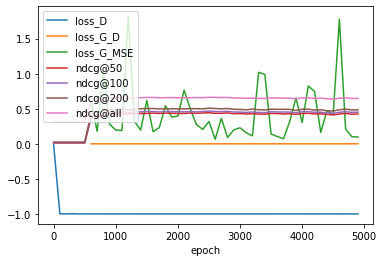

In [58]:
pd.set_option('display.max_rows', 500)
results_df = pd.DataFrame(results)
results_df.groupby(by=['epoch']).mean().plot()
results_df.groupby(by=['epoch']).mean()
# results_df.groupby(by=['epoch']).mean().iloc[-1]

## Quality Check

In [30]:
# select doc_id and k
doc_id = 4
topk = 50

In [31]:
import colored
from colored import stylize

word_list = dataset.vocab.itos

gt = [word_list[word_idx] for word_idx in np.argsort(tfidf_ans[doc_id])[::-1][:topk]]
pred = [word_list[word_idx] for word_idx in np.argsort(model.emb.weight.data[doc_id].numpy())[::-1][:topk]]

print('ground truth')
for word in gt:
    if word in pred:
        print(stylize(word, colored.bg("yellow")), end=' ')
    else:
        print(word, end=' ')

print()
print('\nprediction')
for word in pred:
    if word in gt:
        print(stylize(word, colored.bg("yellow")), end=' ')
    else:
        print(word, end=' ')


ground truth
warren brook sailor mel flesh slapstick lesli price ann rent room speak cut inherit richard warp process interpret montag ebert roger 3rd spectacular grin pg g x mislead humour couldnt mankind rapid complex spiritu notion 4th rid dean dimension krell list storm struck hors discern stone cum soap detect current 

prediction
brook warren mel slapstick lesli ann sailor price flesh rent cut pay cabin bedroom jim sit room bill bacon detail speak darker wood student merril fat oil craig freed spoke scarlett pound eat lower walk hurt chop heal london beast escapist fiction shop neeson disbelief mood duck dana jack spike 

In [32]:
dataset.documents[doc_id]

'this is not the typical mel brooks film .  it was much less slapstick than most of his movies and actually had a plot that was followable .  leslie ann warren made the movie ,  she is such a fantastic ,  under-rated actress .  there were some moments that could have been fleshed out a bit more ,  and some scenes that could probably have been cut to make the room to do so ,  but all in all ,  this is worth the price to rent and see it .  the acting was good overall ,  brooks himself did a good job without his characteristic speaking to directly to the audience .  again ,  warren was the best actor in the movie ,  but  " fume "  and  " sailor "  both played their parts well . '

In [33]:
results = {}
   
scores = np.array(model.emb.weight.data)[doc_id].reshape(1, -1)
true_relevance = train_loader.dataset.tfidf_ans[doc_id].reshape(1, -1)

results['ndcg@50'] = (ndcg_score(true_relevance, scores, k=50))
results['ndcg@100'] = (ndcg_score(true_relevance, scores, k=100))
results['ndcg@200'] = (ndcg_score(true_relevance, scores, k=200))
results['ndcg@all'] = (ndcg_score(true_relevance, scores, k=None))

print('NDCG top50', results['ndcg@50'])
print('NDCG top100', results['ndcg@100'])
print('NDCG top200', results['ndcg@200'])
print('NDCG ALL', results['ndcg@all'])


NDCG top50 0.9834934040761217
NDCG top100 0.9834934040761217
NDCG top200 0.9834934040761217
NDCG ALL 0.9834934040761217


## train seperately

In [34]:
# def evaluate_GAN_NDCG(w, tfidf_ans, doc_id, verbose=1):
#     results = {}
    
#     scores = w.detach().numpy().reshape(1, -1)
#     true_relevance = tfidf_ans[doc_id].reshape(1, -1)

    
#     results['ndcg@50'] = (ndcg_score(true_relevance, scores, k=50))
#     results['ndcg@100'] = (ndcg_score(true_relevance, scores, k=100))
#     results['ndcg@200'] = (ndcg_score(true_relevance, scores, k=200))
#     results['ndcg@all'] = (ndcg_score(true_relevance, scores, k=None))
    
#     if verbose == 1:
#         print('NDCG top50', results['ndcg@50'])
#         print('NDCG top100', results['ndcg@100'])
#         print('NDCG top200', results['ndcg@200'])
#         print('NDCG ALL', results['ndcg@all'])
    
#     return results

In [35]:
# lr = 0.001
# n_epoch = 1000

# n_critic = 1
# clip_value = 1
# bs = 1
# loss_weight = [0, 1]

# num_words = word_vectors.shape[0]
# results_all = []

# for doc_id in tqdm(range(len(document_vectors_tensor[:10]))):
#     doc_emb = document_vectors_tensor[doc_id]
#     test_word_weight_tensor = torch.FloatTensor(np.concatenate((tfidf_ans[:doc_id], tfidf_ans[doc_id+1:])))

#     w = torch.zeros(num_words).requires_grad_(True)
#     D = Discriminator(num_words=num_words, h_dim=64)
#     D.train()

#     # opt_G = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))
#     # opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
#     opt_G = torch.optim.SGD([w], lr=lr)
#     opt_D = torch.optim.SGD(D.parameters(), lr=lr)

#     G_criterion = nn.MSELoss(reduction='mean')
#     D_criterion = nn.BCELoss()

#     results = []
#     for epoch in range(n_epoch):

#         D_loss = []
#         G_loss_D = []
#         G_loss_MSE = []

#         perm = torch.randperm(test_word_weight_tensor.size(0))
#         true_word_weights_sample = test_word_weight_tensor[perm[:bs]]
#         """ Medium: Use WGAN Loss. """
#         # Label
#         r_label = torch.ones((bs))
#         f_label = torch.zeros((bs))

#         # Model forwarding
#         r_logit = D(true_word_weights_sample.detach())
#         f_logit = D(w.detach())

#         # Compute the loss for the discriminator.
#         # r_loss = D_criterion(r_logit.squeeze(), r_label)
#         # f_loss = D_criterion(f_logit.squeeze(), f_label)
#         # loss_D = (r_loss + f_loss) / 2

#         # WGAN Loss
#         loss_D = -torch.mean(r_logit) + torch.mean(f_logit)

#         # Model backwarding
#         D.zero_grad()
#         loss_D.backward()

#         # Update the discriminator.
#         opt_D.step()

#         D_loss.append(loss_D.item())
#         """ Medium: Clip weights of discriminator. """
#         for p in D.parameters():
#             p.data.clamp_(-clip_value, clip_value)

#         # ============================================
#         #  Train G
#         # ============================================
#         if epoch % n_critic == 0:
#             # Generate some fake images.
#             f_logit = D(w)

#             """ Medium: Use WGAN Loss"""
#             # Compute the loss for the generator.
#             # loss_G_Dis = D_criterion(f_logit.squeeze(), r_label)
#             # WGAN Loss
#             loss_G_Dis = -torch.mean(f_logit)

#             # MSE loss
#             pred_doc_embs = w @ word_vectors_tensor
#             loss_G_MSE = G_criterion(pred_doc_embs, doc_emb)

#             loss_G = loss_G_Dis * loss_weight[0] + loss_G_MSE * loss_weight[1]

#             # Model backwarding
#             if w.grad is not None:
#                 w.grad.zero_()
            
#             loss_G.backward()
            
#             # Update the generator.
#             opt_G.step()

#             G_loss_D.append(loss_G_Dis.item())
#             G_loss_MSE.append(loss_G_MSE.item())
        
#         if epoch % 20 == 0:
#             res = {}
#             res['epoch'] = epoch
#             res['loss_D'] = np.mean(D_loss)
#             res['loss_G_D'] = np.mean(G_loss_D)
#             res['loss_G_MSE'] = np.mean(G_loss_MSE)
            
#             print('epoch', epoch)
#             print('loss D', np.mean(D_loss))
#             print('loss G D', np.mean(G_loss_D))
#             print('loss G MSE', np.mean(G_loss_MSE))
            
#             res_ndcg = evaluate_GAN_NDCG(w, tfidf_ans, doc_id)
#             res.update(res_ndcg)
#             results.append(res)

#     results_all.append(results)

In [36]:
# results_df = []
# for r in results_all:
#     r = pd.DataFrame(r)
#     results_df.append(r)

# results_df = pd.concat(results_df)
# results_df.groupby(by=['epoch']).mean().plot()
# results_df.groupby(by=['epoch']).mean()
# # results_df.groupby(by=['epoch']).mean().iloc[-1]

## DNN
1. input: doc vec / output: tfidf weight
2. eval: ndcg
3. model: dnn, rank loss or mse loss

In [37]:
class DNNDataset(Dataset):
    def __init__(self, 
                 doc_vectors,
                 tfidf_ans,
                 ):
        self.doc_vectors = doc_vectors
        self.tfidf_ans = tfidf_ans
        assert len(doc_vectors) == len(tfidf_ans)
        
    def __getitem__(self, idx):
        # doc vec, tfidf-ans, doc_id
        doc_vec = torch.FloatTensor(self.doc_vectors[idx])
        tfidf_ans = torch.FloatTensor(self.tfidf_ans[idx])
        
        return doc_vec, tfidf_ans

    def __len__(self):
        return len(self.doc_vectors)


In [38]:
document_vectors = np.array(dataset.document_vectors)

len(document_vectors)
train_test_split_ratio = 0.8
select_num = int(len(document_vectors) * train_test_split_ratio)

train_dataset = DNNDataset(document_vectors[:select_num], tfidf_ans[:select_num])
valid_dataset = DNNDataset(document_vectors[select_num:], tfidf_ans[select_num:])

train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(valid_dataset, batch_size=100, shuffle=True, pin_memory=True)


In [39]:
class DNN(nn.Module):
    def __init__(self, doc_emb_shape, num_words, h_dim=64):
        super().__init__()
        
        self.fc1 = nn.Linear(doc_emb_shape, h_dim) 
        self.fc2 = nn.Linear(h_dim, h_dim)
        self.fc3 = nn.Linear(h_dim, num_words)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [40]:
def evaluate_DNN(test_loader, model):

    results = {}
    model.eval()
    
    total_loss = []
    scores = []
    true_relevance = []
    
    with torch.no_grad():
        for data in test_loader:
            doc_embs, target = data
            predicted = model(doc_embs)  
            loss = criterion(predicted, target)  # compare the predicted labels with ground-truth labels
            total_loss.append(loss.item())
            scores.append(predicted.detach().numpy())
            true_relevance.append(target.detach().numpy())
    
    scores = np.concatenate(scores)
    true_relevance = np.concatenate(true_relevance)
    
    results['ndcg@50'] = (ndcg_score(true_relevance, scores, k=50))
    results['ndcg@100'] = (ndcg_score(true_relevance, scores, k=100))
    results['ndcg@200'] = (ndcg_score(true_relevance, scores, k=200))
    results['ndcg@all'] = (ndcg_score(true_relevance, scores, k=None))
    results['mse'] = np.mean(total_loss)
    
    print('Valid loss:',results['mse'])
    print('NDCG top50', results['ndcg@50'])
    print('NDCG top100', results['ndcg@100'])
    print('NDCG top200', results['ndcg@200'])
    print('NDCG ALL', results['ndcg@all'])
    
    return results

In [41]:
# lr = 0.001
# h_dim = 64
# model = DNN(document_vectors.shape[1], tfidf_ans.shape[1], h_dim)
# optimizer = optim.Adam(model.parameters(), lr=0.001)  # create a Adam optimizer

# criterion = nn.MSELoss()
# epochs = 100
# results = []

# for epoch in range(epochs):
#     total_loss = []
#     for data in train_loader:
#         doc_embs, target = data
#         # training process
#         optimizer.zero_grad()    
#         predicted = model(doc_embs)  
#         loss = criterion(predicted, target)  # compare the predicted labels with ground-truth labels
#         loss.backward()      # compute the gradient
#         optimizer.step()     # optimize the network
#         total_loss.append(loss.item())
        
#     print(f'epoch:{epoch}')
#     print(f'Training loss:{np.mean(total_loss)}')
    
#     res = evaluate_DNN(test_loader, model)
#     results.append(res)
    

In [42]:
# results = pd.DataFrame(results)
# results.plot()

## Lasso

In [43]:
# select #answer largest pred
def metric4(binary_x, answer, w_idx=None, topk=50, verbose=0):
    select_num = topk
    answer = list(set(answer))
    
    if w_idx is not None:
        pred = w_idx[np.argsort(binary_x)[-select_num:]]
    else:
        pred = np.arange(len(binary_x))[np.argsort(binary_x)[-select_num:]]
    
    hit = np.intersect1d(pred, answer)
    hit_num = len(hit)
    recall = hit_num / len(answer)
    precision = hit_num / len(pred)
    if verbose == 1:
        print('answer:', word_list[answer])
        print('hit:', word_list[hit])
    return {"recall": recall, "precision": precision}

def metric_ndcg(binary_x, answer, topk=50, verbose=0):

    TFIDF_ans = np.zeros(len(binary_x))
    for word_idx in answer:
        if word_idx == 0:
            continue
        word = dataset.vocab.itos[word_idx]
        TFIDF_ans[word_idx] += dataset.vocab.IDF[word]
    NDCG_score = ndcg_score(TFIDF_ans.reshape(1,-1), binary_x.reshape(1,-1), k=topk)
    
    if verbose == 1:
        print('NDCG_score:', NDCG_score)
    return NDCG_score

def metric_ndcg2(binary_x, tfidf_ans, doc_id, topk=50, verbose=0):
    NDCG_score = ndcg_score(tfidf_ans[doc_id].reshape(1,-1), binary_x.reshape(1,-1), k=topk)
    
    if verbose == 1:
        print('NDCG_score:', NDCG_score)
    return NDCG_score

In [44]:
from sklearn.metrics import r2_score

class PyTorchLinearRegression:
    ''' Class that implemnets Multiple Linear Regression with PyTorch'''
    def __init__(self, num_of_features, lr, constraintHigh, constraintLow, total, init_type=0, L1=0, L2=0):
        if init_type == 0:
            self.w = torch.zeros(num_of_features, requires_grad=True)
        elif init_type == 1:
            self.w = torch.ones(num_of_features, requires_grad=True)
        elif init_type == 2:  
            self.w = torch.rand(num_of_features, requires_grad=True)
        elif init_type == 3:
            self.w = -torch.ones(num_of_features, requires_grad=True)

        self.learning_rate = lr
        self.high = constraintHigh
        self.low = constraintLow
        self.total = total
        self.rg2 = total / num_of_features
        self.L1 = L1
        self.L2 = L2
        
    def _model(self, X):
        return X @ self.w.t()# + self.b
    
    def _mse(self, pred, real):
        difference = pred - real
        return torch.sum(difference * difference) / difference.numel()
    
    def _regularization_weightdist(self):
        difference = self.w - 1
        return -torch.sum(difference * difference) / difference.numel()
    
    def _regularization_weightsum(self):
        difference = torch.sum(self.w) - self.total
        return difference * difference / self.w.numel()
    
    def fit(self, X, y, epochs):
        print(loss_weight)
        
        X = torch.from_numpy(X).float()
        y = torch.from_numpy(y).float()

        for i in range(epochs):
            predictions = self._model(X)
            loss1 = self._mse(predictions, y)
            loss2 = self._regularization_weightdist()
            loss3 = self._regularization_weightsum()
            loss = loss1 * loss_weight[0] + loss2 * loss_weight[1] + loss3 * loss_weight[2]

            if (i % (epochs//20)) == 0:
                print(f'Epoch: {i} - Loss: {loss1}')
            
            if self.w.grad is not None:
                self.w.grad.zero_()
            
            loss.backward()
            with torch.no_grad():
                self.w -= (self.w.grad) * self.learning_rate + torch.sign(self.w)*self.L1 + self.w*self.L2
                self.w.data.clamp_(min=self.low, max=self.high)
#                 self.w.grad.zero_()
#             x = 100
#             if i % x == x-1:
# #                 self.w=torch.tensor(self.low + (self.high-self.low)*(self.w - torch.min(self.w))/(torch.max(self.w) - torch.min(self.w)), requires_grad=True)
#                 self.w.data.clamp_(min=self.low, max=self.high)
#                 pass
                
    def predict(self, X):
        X = torch.from_numpy(X).float()
        return self._model(X)
    
    def score(self, X, y):
        X = torch.from_numpy(X).float()
        y_pred = self._model(X).detach().numpy()
        return r2_score(y, y_pred)

In [45]:
word_embs = np.array(dataset.vocab.word_vectors)
doc_embs = np.array(dataset.document_vectors)
doc_answers = dataset.document_answers
word_list = dataset.vocab.itos

print(word_embs.shape)
print(doc_embs.shape)
print(len(doc_answers))


(4127, 100)
(9993, 100)
9993


In [46]:
# pr, re = [[],[],[]], [[],[],[]]
# ndcgs = defaultdict(list)

# lr = 0.003
# epochs = 10000
# constraintHigh=1
# constraintLow=0
# # constraintHigh=float('inf')
# # constraintLow=-float('inf')
# loss_weight = [1, 0, 1]
# L1, L2 = 0, 0
# rand_type = 0

# total_mul = 1

# for uid, uemb in enumerate(tqdm(doc_embs[:50])):
#     x = word_embs.T
#     y = uemb
#     total = len(doc_answers[uid])
#     total = 1
    
#     torch_model = PyTorchLinearRegression(x.shape[1], lr, constraintHigh, constraintLow, int(total*total_mul), rand_type, L1, L2)
#     torch_model.fit(x, y, epochs)
    
#     m1 = metric4(torch_model.w.detach().numpy(), doc_answers[uid], w_idx=None, topk=50, verbose=0)
#     m2 = metric4(torch_model.w.detach().numpy(), doc_answers[uid], w_idx=None, topk=100, verbose=0)
#     m3 = metric4(torch_model.w.detach().numpy(), doc_answers[uid], w_idx=None, topk=200, verbose=0)
#     ndcg1 = metric_ndcg2(torch_model.w.detach().numpy(), tfidf_ans, uid, topk=50, verbose=0)
#     ndcg2 = metric_ndcg2(torch_model.w.detach().numpy(), tfidf_ans, uid, topk=100, verbose=0)
#     ndcg3 = metric_ndcg2(torch_model.w.detach().numpy(), tfidf_ans, uid, topk=200, verbose=0)
#     ndcg4 = metric_ndcg2(torch_model.w.detach().numpy(), tfidf_ans, uid, topk=None, verbose=0)
#     pr[0].append(m1["precision"])
#     re[0].append(m1["recall"])
#     pr[1].append(m2["precision"])
#     re[1].append(m2["recall"])
#     pr[2].append(m3["precision"])
#     re[2].append(m3["recall"])
    
#     ndcgs["50"].append(ndcg1)
#     ndcgs["100"].append(ndcg2)
#     ndcgs["200"].append(ndcg3)
#     ndcgs["-1"].append(ndcg4)

In [47]:
# print(f"Precision:{np.mean(pr[0]):.4f} Recall:{np.mean(re[0]):.4f}")
# print(f"Precision:{np.mean(pr[1]):.4f} Recall:{np.mean(re[1]):.4f}")
# print(f"Precision:{np.mean(pr[2]):.4f} Recall:{np.mean(re[2]):.4f}")
# print(f"NDCG 50:{np.mean(ndcgs['50']):.4f}")
# print(f"NDCG 100:{np.mean(ndcgs['100']):.4f}")
# print(f"NDCG 200:{np.mean(ndcgs['200']):.4f}")
# print(f"NDCG all:{np.mean(ndcgs['-1']):.4f}")


## Nearest Guessing, so bad

In [48]:
word_embs_IDF = word_embs.copy()

for word, IDF in dataset.vocab.IDF.items():
    word_idx = dataset.vocab.stoi[word]
    word_embs_IDF[word_idx] *= IDF

In [49]:
pr, re = [[],[],[]], [[],[],[]]
ndcgs = defaultdict(list)

for uid, uemb in enumerate(tqdm(doc_embs[:100])):
    y = uemb
    word_embs_IDF
    word_weight = np.dot(word_embs_IDF, y)
    
    m1 = metric4(word_weight, doc_answers[uid], w_idx=None, topk=50, verbose=0)
    m2 = metric4(word_weight, doc_answers[uid], w_idx=None, topk=100, verbose=0)
    m3 = metric4(word_weight, doc_answers[uid], w_idx=None, topk=200, verbose=0)
    ndcg1 = metric_ndcg(word_weight, doc_answers[uid], topk=50, verbose=0)
    ndcg2 = metric_ndcg(word_weight, doc_answers[uid], topk=100, verbose=0)
    ndcg3 = metric_ndcg(word_weight, doc_answers[uid], topk=200, verbose=0)
    ndcg4 = metric_ndcg(word_weight, doc_answers[uid], topk=None, verbose=0)
    pr[0].append(m1["precision"])
    re[0].append(m1["recall"])
    pr[1].append(m2["precision"])
    re[1].append(m2["recall"])
    pr[2].append(m3["precision"])
    re[2].append(m3["recall"])
    
    ndcgs["50"].append(ndcg1)
    ndcgs["100"].append(ndcg2)
    ndcgs["200"].append(ndcg3)
    ndcgs["-1"].append(ndcg4)

  0%|          | 0/100 [00:00<?, ?it/s]

In [50]:
print(f"Precision:{np.mean(pr[0]):.4f} Recall:{np.mean(re[0]):.4f}")
print(f"Precision:{np.mean(pr[1]):.4f} Recall:{np.mean(re[1]):.4f}")
print(f"Precision:{np.mean(pr[2]):.4f} Recall:{np.mean(re[2]):.4f}")
print(f"NDCG 50:{np.mean(ndcgs['50']):.4f}")
print(f"NDCG 100:{np.mean(ndcgs['100']):.4f}")
print(f"NDCG 200:{np.mean(ndcgs['200']):.4f}")
print(f"NDCG all:{np.mean(ndcgs['-1']):.4f}")


Precision:0.0380 Recall:0.1146
Precision:0.0303 Recall:0.1675
Precision:0.0250 Recall:0.2413
NDCG 50:0.1190
NDCG 100:0.1403
NDCG 200:0.1673
NDCG all:0.3492


In [51]:
# ## test dcg
# from sklearn.metrics import ndcg_score, dcg_score
# k=2

# true_relevance = np.asarray([[1, 2, 3, 4]])
# scores = np.asarray([[1, 2, 3, 2.5]])
# print('dcg',dcg_score(true_relevance, scores,k=k))
# print('ndcg',ndcg_score(true_relevance, scores,k=k))


# w = 1 / (np.log(np.arange(true_relevance.shape[1])[:k] + 2) / np.log(2))
# dcg = true_relevance[0][np.argsort(scores)[0][::-1][:k]].dot(w)
# print(dcg)

# idcg = np.sort(true_relevance[0])[::-1][:k].dot(w)
# print(dcg/idcg)